# Kernel Methods

Credit: Prof. Dan Sheldon, who released this as "12-demo.ipynb"

Source: https://people.cs.umass.edu/~sheldon/teaching/cs335/


## First Problem: 1D Non-Linear Regression

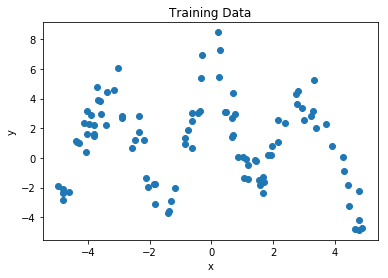

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
import sklearn.kernel_ridge
import sklearn.metrics.pairwise
from matplotlib.colors import ListedColormap

def plot_model(X_test, clf):
    '''
    Note: uses globals x, y, x_test, which are assigned below
    when the dataset is created. Don't overwrite these variables.
    '''
    y_test = clf.predict(X_test)
    plt.scatter(x_train, y_train)
    plt.plot(x_test, y_test)
    plt.legend(['Test', 'Train'])
    
# Set random seed
np.random.seed(0)

# Create random set of N training x values between -5 and 5
N = 100
x_train = np.random.rand(N)*10 - 5

# Create evenly spaced test x values (for plotting)
x_test  = np.linspace(-5, 5, 505)
m_test  = len(x_test);

def f(x):
    return 0.5*np.cos(x) + np.sin(x) + 4*np.cos(2*x) + np.exp(np.cos(3*x))


y_train = f(x_train) + np.random.randn(N)   # function plus noise

x_train = x_train.reshape(-1, 1)
x_test  = x_test.reshape(-1, 1)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Standard Linear Regression

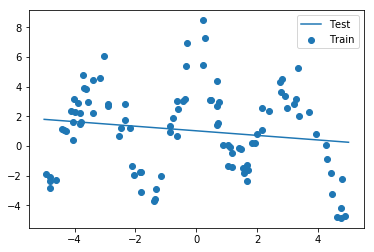

In [2]:
clf = sklearn.linear_model.LinearRegression()
clf.fit(x_train, y_train)
plot_model(x_test, clf)

## Kernel Trick for Linear Regression

Suppose $\theta$ can be rewritten as a linear combination of the feature vectors, i.e., $\theta = \sum_{i=1}^m \alpha_i x^{(i)}$. Then we have that
$$
h_{\theta}(x) = \theta^T x = \sum_{i=1}^m \alpha_i (x^{(i)})^T x = \sum_{i=1}^m \alpha_i K(x^{(i)}, x)
$$
where $K(x,z) := x^T z$, the "kernel function", computes the dot product between $x$ and $z$.

We can rewrite this one more time to get
$$
h_{\theta}(x) = \sum_{i=1}^m \alpha_i K(x^{(i)}, x) = \alpha^T k(x)
$$
where
$$
\begin{aligned}
\alpha &= \begin{bmatrix}\alpha_1, \ldots, \alpha_m\end{bmatrix}^T \\
 k(x) &= \begin{bmatrix}K(x^{(1)}, x), & K(x^{(2)}, x), & \ldots, & K(x^{(m)},x)\end{bmatrix}^T
\end{aligned}
$$

We can think this as a new linear regression problem with parameter vector $\alpha$ and a feature mapping that maps $x$ the vector $k(x)$ of kernel comparisons between $x$ and every training point. 

Applying the feature mapping to every row of the original data matrix $X$ yields a "kernel matrix" $K$ defined by $K_{ij} = K(x^{(i)}, x^{(j)})$.

If our assumption holds that the *best* $\theta$ (the one that achieves minimum cost) can be expressed as a linear combination of feature vectors, then there is some choice for the parameter vector $\alpha$ that will yield this best hypothesis. So, it suffices to look values of $\alpha$ that minimize the squared error in this new linear regression problem. That is, we can simply solve the new linear regression problem where we replace the data matrix by the kernel matrix!

Note: this is not generally how we solve for $\alpha$ in practice, but it is concrete proof that we can solve the learning and prediction problems while only accessing the data (feature vectors) through dot products.


In [3]:
def linear_kernel(X, Z):
    '''
    Compute dot product between each row of X and each row of Z
    '''
    m1,_ = X.shape
    m2,_ = Z.shape
    K = np.zeros((m1, m2))
    for i in range(m1):
        for j in range(m2):
            K[i,j] = np.dot(X[i,:], Z[j,:])
    return K

K_train = linear_kernel(x_train, x_train) + 1e-10 * np.eye(N)  # see note below
K_test  = linear_kernel(x_test,  x_train)

print("Shape of K_train: %s" % str(K_train.shape))
print("Shape of K_test: %s" % str(K_test.shape))

Shape of K_train: (100, 100)
Shape of K_test: (505, 100)


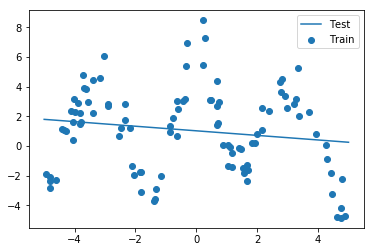

In [4]:
clf = sklearn.linear_model.LinearRegression()
clf.fit(K_train, y_train)
plot_model(K_test, clf)

### [Optional; advanced] Why do we add 1e-10 * np.eye(N) to K_train?

It turns out that our assumption that $\theta = \sum_{i=1}^N \alpha_i x^{(i)}$ needs to be refined slightly.

Let's consider the parameter vector $\theta^*$ that minimizes the cost function $J(\theta) = \frac{1}{2}\sum_{i=1}^N \big(\theta^T x^{(i)} - y^{(i)}\big)^2$. 
It is true that there is *some* $\alpha$ such that $\theta^* = \sum_{i=1}^N K(x^{(i)}, x)$. So, we can minimize the cost function by searching over $\alpha$ instead. But there might be *many* different vectors $\alpha$ that achieve the same cost, so minimizing $J(\alpha) = \frac{1}{2}\sum_{i=1}^N \big(\alpha^T k(x^{(i)}) - y^{(i)}\big)^2$ is not guaranteed to find the vector $\alpha$ that corresponds to $\theta^*$. 

However, if we instead add even a tiny bit of regularization to our training objective, we are guaranteed to exactly recover $\theta^*$. This is a result known as the *representer* theorem. 

Try changing this to
``` .python
K_train = linear_kernel(x_train, x_train)
```
You will see that the learned model is slightly wiggly, i.e., the learned $\theta$ does not *exactly* correspond to a hypothesis in the original hypothesis class. But it should have the same cost as $\theta^*$ to within a very small tolerance. 

## Polynomial Kernel

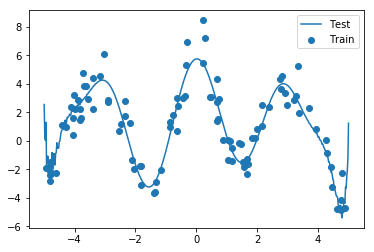

In [5]:
# Explicit definition
def polynomial_kernel(X, Z, d):
    '''
    Compute dot product between each row of X and each row of Z
    '''
    m1,_ = X.shape
    m2,_ = Z.shape
    K = np.zeros((m1, m2))
    for i in range(m1):
        for j in range(m2):
            K[i,j] = (np.dot(X[i,:], Z[j,:]) + 1)**d
    return K


# Better version: use sklearn.metrics.pairwise.polynomial_kernel

# Set the degree of the polynomial
d = 12
K_train = sklearn.metrics.pairwise.polynomial_kernel(x_train, x_train, degree=d)
K_test  = sklearn.metrics.pairwise.polynomial_kernel(x_test,  x_train, degree=d)

K_train = K_train + 1e-10*np.eye(N)

clf = sklearn.linear_model.LinearRegression()
clf.fit(K_train, y_train)
plot_model(K_test, clf)

## Gaussian Kernel

In [6]:
# Here is an explicit defintion
def gaussian_kernel(X, Z, gamma):
    '''
    Compute dot product between each row of X and each row of Z
    '''    
    m1 = X.shape[0]
    m2 = Z.shape[0]
    
    K = np.zeros((m1, m2))
    
    for i in range(m1):
        for j in range(m2):
            K[i,j] = np.exp( -gamma * np.linalg.norm(X[i,:] - Z[j,:])**2 )
            
    return K

# Better version: use sklearn.metrics.pairwise.rbf_kernel
#   rbf = "radial basis function"

##  Gaussian Kernel Intuition

$$K(\mathbf{x}, \mathbf{z}) = \exp (- \gamma ||\mathbf{x} - \mathbf{z}||^2 )$$

Intepret as *similarity function*

* Equal to 1 when $\mathbf{x} = \mathbf{z}$
* Decays exponentially as $\mathbf{z}$ and $\mathbf{x}$ get farther apart
* Smaller $\gamma$ -> slower decay
* Larger $\gamma$ -> faster decay


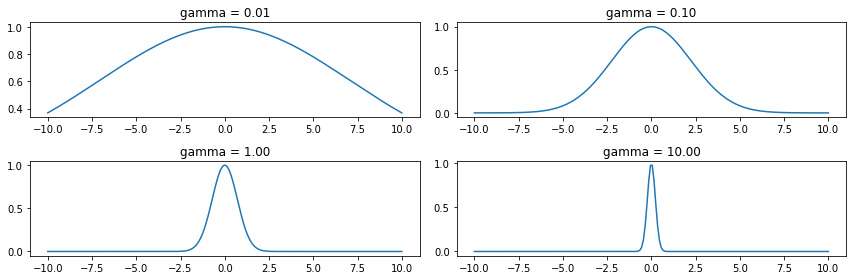

In [7]:
gamma_vals = [0.01, 0.1, 1, 10]

x    = np.linspace(-10, 10, 200).reshape(-1,1)
zero = np.array([[0]])

n_plots = len(gamma_vals)

plt.figure(figsize=(12, 4))

for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    k = sklearn.metrics.pairwise.rbf_kernel(x, zero, gamma=gamma_vals[i])
    plt.plot(x, k)
    plt.title('gamma = %.2f' % (gamma_vals[i]))

plt.tight_layout()
plt.show()

## Linear Regression with Gaussian Kernel

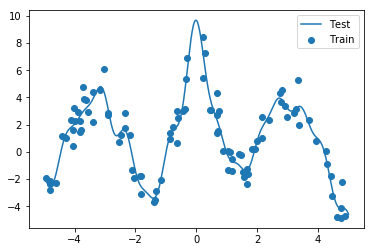

In [8]:
gamma = 3   # Try different values of gamma!!
#gamma = 1

# Matrix of similarities between training points
K_train = sklearn.metrics.pairwise.rbf_kernel(x_train, x_train, gamma=gamma) + 1e-2*np.eye(N)

# ith row = similarity of ith test point to all training points
K_test  = sklearn.metrics.pairwise.rbf_kernel(x_test,  x_train, gamma=gamma) 

clf = sklearn.linear_model.LinearRegression()
clf.fit(K_train, y_train)
plot_model(K_test, clf)

## Linear Regression with Gaussian Kernel and Regularization

**Tip**: use regularization with kernel methods.
**Tip**: don't form the kernel matrix yourself. Use an optimization routine that allows you to specify the kernel.

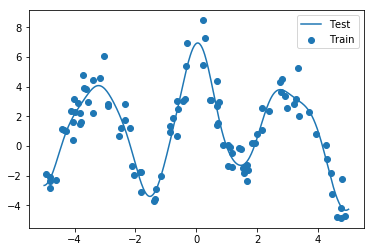

In [9]:
from sklearn import kernel_ridge

lambda_val = 0.01
gamma = 1

clf = kernel_ridge.KernelRidge(alpha=lambda_val, kernel='rbf', gamma=gamma)
clf.fit(x_train, y_train)
plot_model(x_test, clf)

# Second Problem: 2D Non-Linear Classification

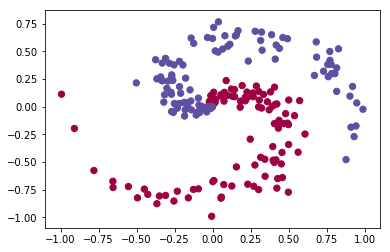

In [10]:
N = 100  # number of points per class
D = 2   # dimensionality
K = 2   # number of classes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K) # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.4 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

## Plotting Setup

In [11]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()]
labels=['or','ob']

def plot_model(X_test, clf):
    Z = clf.predict(X_test)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    
    # Plot also the training points
    #plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    for i in [0, 1]:
        plt.plot(X[y==i, 0], X[y==i, 1], labels[i])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #plt.contourf(xx, yy, Z, alpha=1, cmap=cmap_light)
    plt.pcolormesh(xx, yy, Z,cmap=cmap_light)


## Kernelized Logistic Regression

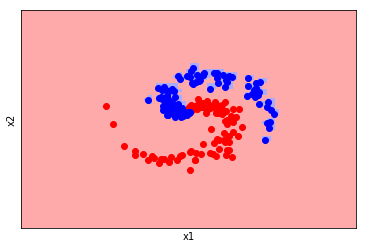

In [12]:
#gamma = 0.01
#gamma = 0.1
#gamma = 1
gamma = 10
gamma = 1000

K      = sklearn.metrics.pairwise.rbf_kernel(X, X, gamma=gamma)
K_test = sklearn.metrics.pairwise.rbf_kernel(X_test, X, gamma=gamma)

clf = sklearn.linear_model.LogisticRegression(solver='lbfgs')
clf.fit(K, y)

plot_model(K_test, clf)


## SVM Loss Function

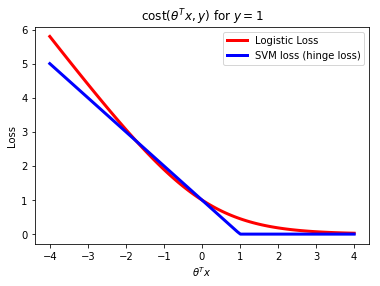

In [13]:
def plot_loss():
    xmin, xmax = -4, 4
    xx = np.linspace(xmin, xmax, 100)

    plt.figure()
    plt.plot(xx, np.log2(1 + np.exp(-xx)), 'r-',linewidth=3)
    plt.plot(xx, np.where(xx < 1, 1 - xx, 0), 'b-',linewidth=3)
    plt.xlabel(r"$\theta^T x$")
    plt.ylabel("Loss")
    plt.legend(["Logistic Loss", "SVM loss (hinge loss)"])
    plt.title(r"cost($\theta^T x, y)$ for $y = 1$")
    plt.show()
    
plot_loss()

## SVM Classification

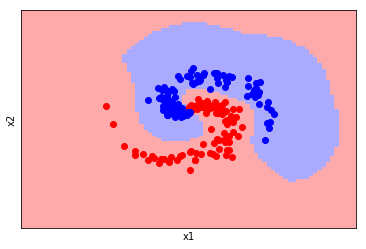

In [14]:
#gamma = 0.01
#gamma = 0.1
#gamma = 1
gamma = 10

C = 10 # C = 2/lambda

clf = sklearn.svm.SVC(C=C, kernel='rbf', gamma=gamma)
clf.fit(X, y)
plot_model(X_test, clf)


## SVM vs Kernelized Logistic Regression

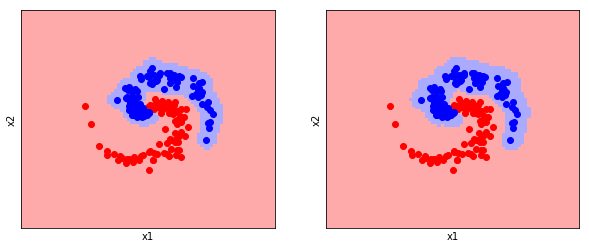

In [15]:
C = 1000
gamma = 100

# Fit kernelized logistic regression
K      = sklearn.metrics.pairwise.rbf_kernel(X, X, gamma=gamma)
K_test = sklearn.metrics.pairwise.rbf_kernel(X_test, X, gamma=gamma)
logistic = sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs')
logistic.fit(K, y)

# Fit SVM with same parameter
svm = sklearn.svm.SVC(C=C, kernel='rbf', gamma=gamma)
svm.fit(X, y)

plt.figure(figsize=(10,4))
plt.subplot(121)
plot_model(K_test, logistic)

plt.subplot(122)
plot_model(X_test, svm)
